# Try do do a 3D registration of the pelvic floor scans
This notebook is *heavily* based on http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

In [1]:
import platform
import os
import pandas
import glob
from tqdm.auto import tqdm
import dask_image.imread
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import napari

In [208]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300

In [3]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [164]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-djonov')
elif 'Darwin' in platform.system():
    # First mount smb://resstore.unibe.ch/ana_rs_djonov/data in the Finder
    FastSSD = False
    BasePath = os.path.join('/Volumes/data/')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('V:\\')
        else:
            BasePath = os.path.join('V:\\')
Root = os.path.join(BasePath, 'Aaldijk')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Aaldijk


In [165]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [166]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [167]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [168]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [169]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

- Foetus02_Lugol_15pct_151d/proj/Foetus02_Lugol_15pct_151d.log is missing matching reconstructions


In [170]:
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*.csv')) for f in Data['Folder']]

In [171]:
# Check for samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not len(row.XYAlignment):
            if not any(x in row.LogFile for x in ['rectmp.log']):
                # 'rectmp.log' because we only exclude it afterwards :)
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root)+1:])

- Foetus02_Lugol_15pct_151d/proj/Foetus02_Lugol_15pct_151d.log has *not* been X/Y aligned


In [172]:
# Get rid of all logfiles we don't want
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:  # drop all non-rec folders
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:  # drop all partial reconstructions which might be there from synchronization
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:  # drop all temporary logfiles
        Data.drop([c], inplace=True)
    elif 'Foetus01' in row.LogFile:  # drop this sample, which we don't need
        Data.drop([c], inplace=True)
    elif 'rec_old' in row.LogFile:  # drop the 'old' reconstructions with varying gray values
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [173]:
# Generate us some meaningful colums
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [174]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [175]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [176]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [177]:
def get_scandate(logfile, verbose=False):
    """When did we scan the Sample?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
    return(date)

In [178]:
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Time passed'] = [sd - Data['Scan date'].min() for sd in Data['Scan date']]
Data['Days passed'] = [t.round('d') for t in Data['Time passed']]

In [179]:
# Drop high-resolution scans, e.g. only register the quick ones...
Data = Data[Data.Voxelsize > 15]
Data = Data.reset_index(drop=True)

In [193]:
# Load all reconstructions into ephemereal DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/14 [00:00<?, ?it/s]

In [181]:
Data

,LogFile,Folder,XYAlignment,Sample,Scan,Reconstructions,Number of reconstructions,Voxelsize,Scan date,Time passed,Days passed
0,/media/habi/Fast_SSD/Aaldijk/Foetus02/rec/Foet...,/media/habi/Fast_SSD/Aaldijk/Foetus02/rec,[],Foetus02,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02/rec/Foe...,1941,20.000477,2021-10-25 18:46:14,0 days 00:00:00,0 days
1,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_05...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_05...,[],Foetus02_Lugol_05pct_007d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_0...,1941,20.000477,2021-11-08 16:12:19,13 days 21:26:05,14 days
2,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,[],Foetus02_Lugol_10pct_014d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2021-11-15 17:32:52,20 days 22:46:38,21 days
3,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,[],Foetus02_Lugol_10pct_025d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2021-11-26 12:25:21,31 days 17:39:07,32 days
4,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_044d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2021-12-15 17:27:57,50 days 22:41:43,51 days
5,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_053d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2021-12-24 11:00:51,59 days 16:14:37,60 days
6,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_060d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2021-12-31 10:56:23,66 days 16:10:09,67 days
7,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_070d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2022-01-10 11:27:14,76 days 16:41:00,77 days
8,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_077d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2022-01-17 11:23:53,83 days 16:37:39,84 days
9,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_088d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477,2022-01-28 10:50:39,94 days 16:04:25,95 days


In [182]:
# View it in 3D
# viewer = napari.view_image(Reconstructions[14][::4,::4,::4])

In [183]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [184]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [185]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='Middle images', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].squeeze()[:,:,1]
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].squeeze()[:,:,1]
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].squeeze()[:,:,1]
            # Save the calculated 'direction' view to disk           
            imageio.imwrite(outfilepath, Data.at[c, 'Mid_' + direction].astype('uint8'))

Middle images:   0%|          | 0/14 [00:00<?, ?it/s]

Foetus02/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_05pct_007d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_014d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_025d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_044d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_053d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_060d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_070d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_077d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_088d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_098d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_141d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

In [186]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/14 [00:00<?, ?it/s]

Foetus02/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_05pct_007d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_014d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_025d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_044d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_053d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_060d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_070d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_077d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_088d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_098d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_141d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

----
Actually start the registration now

----

In [187]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [189]:
len(Data)

14

In [190]:
Data[['Sample', 'Folder', 'Scan', 'Voxelsize']] 

,Sample,Folder,Scan,Voxelsize
0,Foetus02,/media/habi/Fast_SSD/Aaldijk/Foetus02/rec,rec,20.000477
1,Foetus02_Lugol_05pct_007d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_05...,rec,20.000477
2,Foetus02_Lugol_10pct_014d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,rec,20.000477
3,Foetus02_Lugol_10pct_025d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,rec,20.000477
4,Foetus02_Lugol_15pct_044d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477
5,Foetus02_Lugol_15pct_053d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477
6,Foetus02_Lugol_15pct_060d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477
7,Foetus02_Lugol_15pct_070d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477
8,Foetus02_Lugol_15pct_077d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477
9,Foetus02_Lugol_15pct_088d,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,rec,20.000477


In [191]:
# We need to downsample the image to be actually able to register them
downsample = 4

In [197]:
# Use last scan as fixed image, try to register all other scans to it
fixed_image = sitk.GetImageFromArray(Reconstructions[len(Data)-1][::downsample,::downsample,::downsample])

In [331]:
# Load another scan to register
whichone = 0
moving_image = sitk.GetImageFromArray(Reconstructions[whichone][::downsample,::downsample,::downsample])

In [332]:
# Initialize transformation (as is from SimpleITK notebook)
initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                      moving_image,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

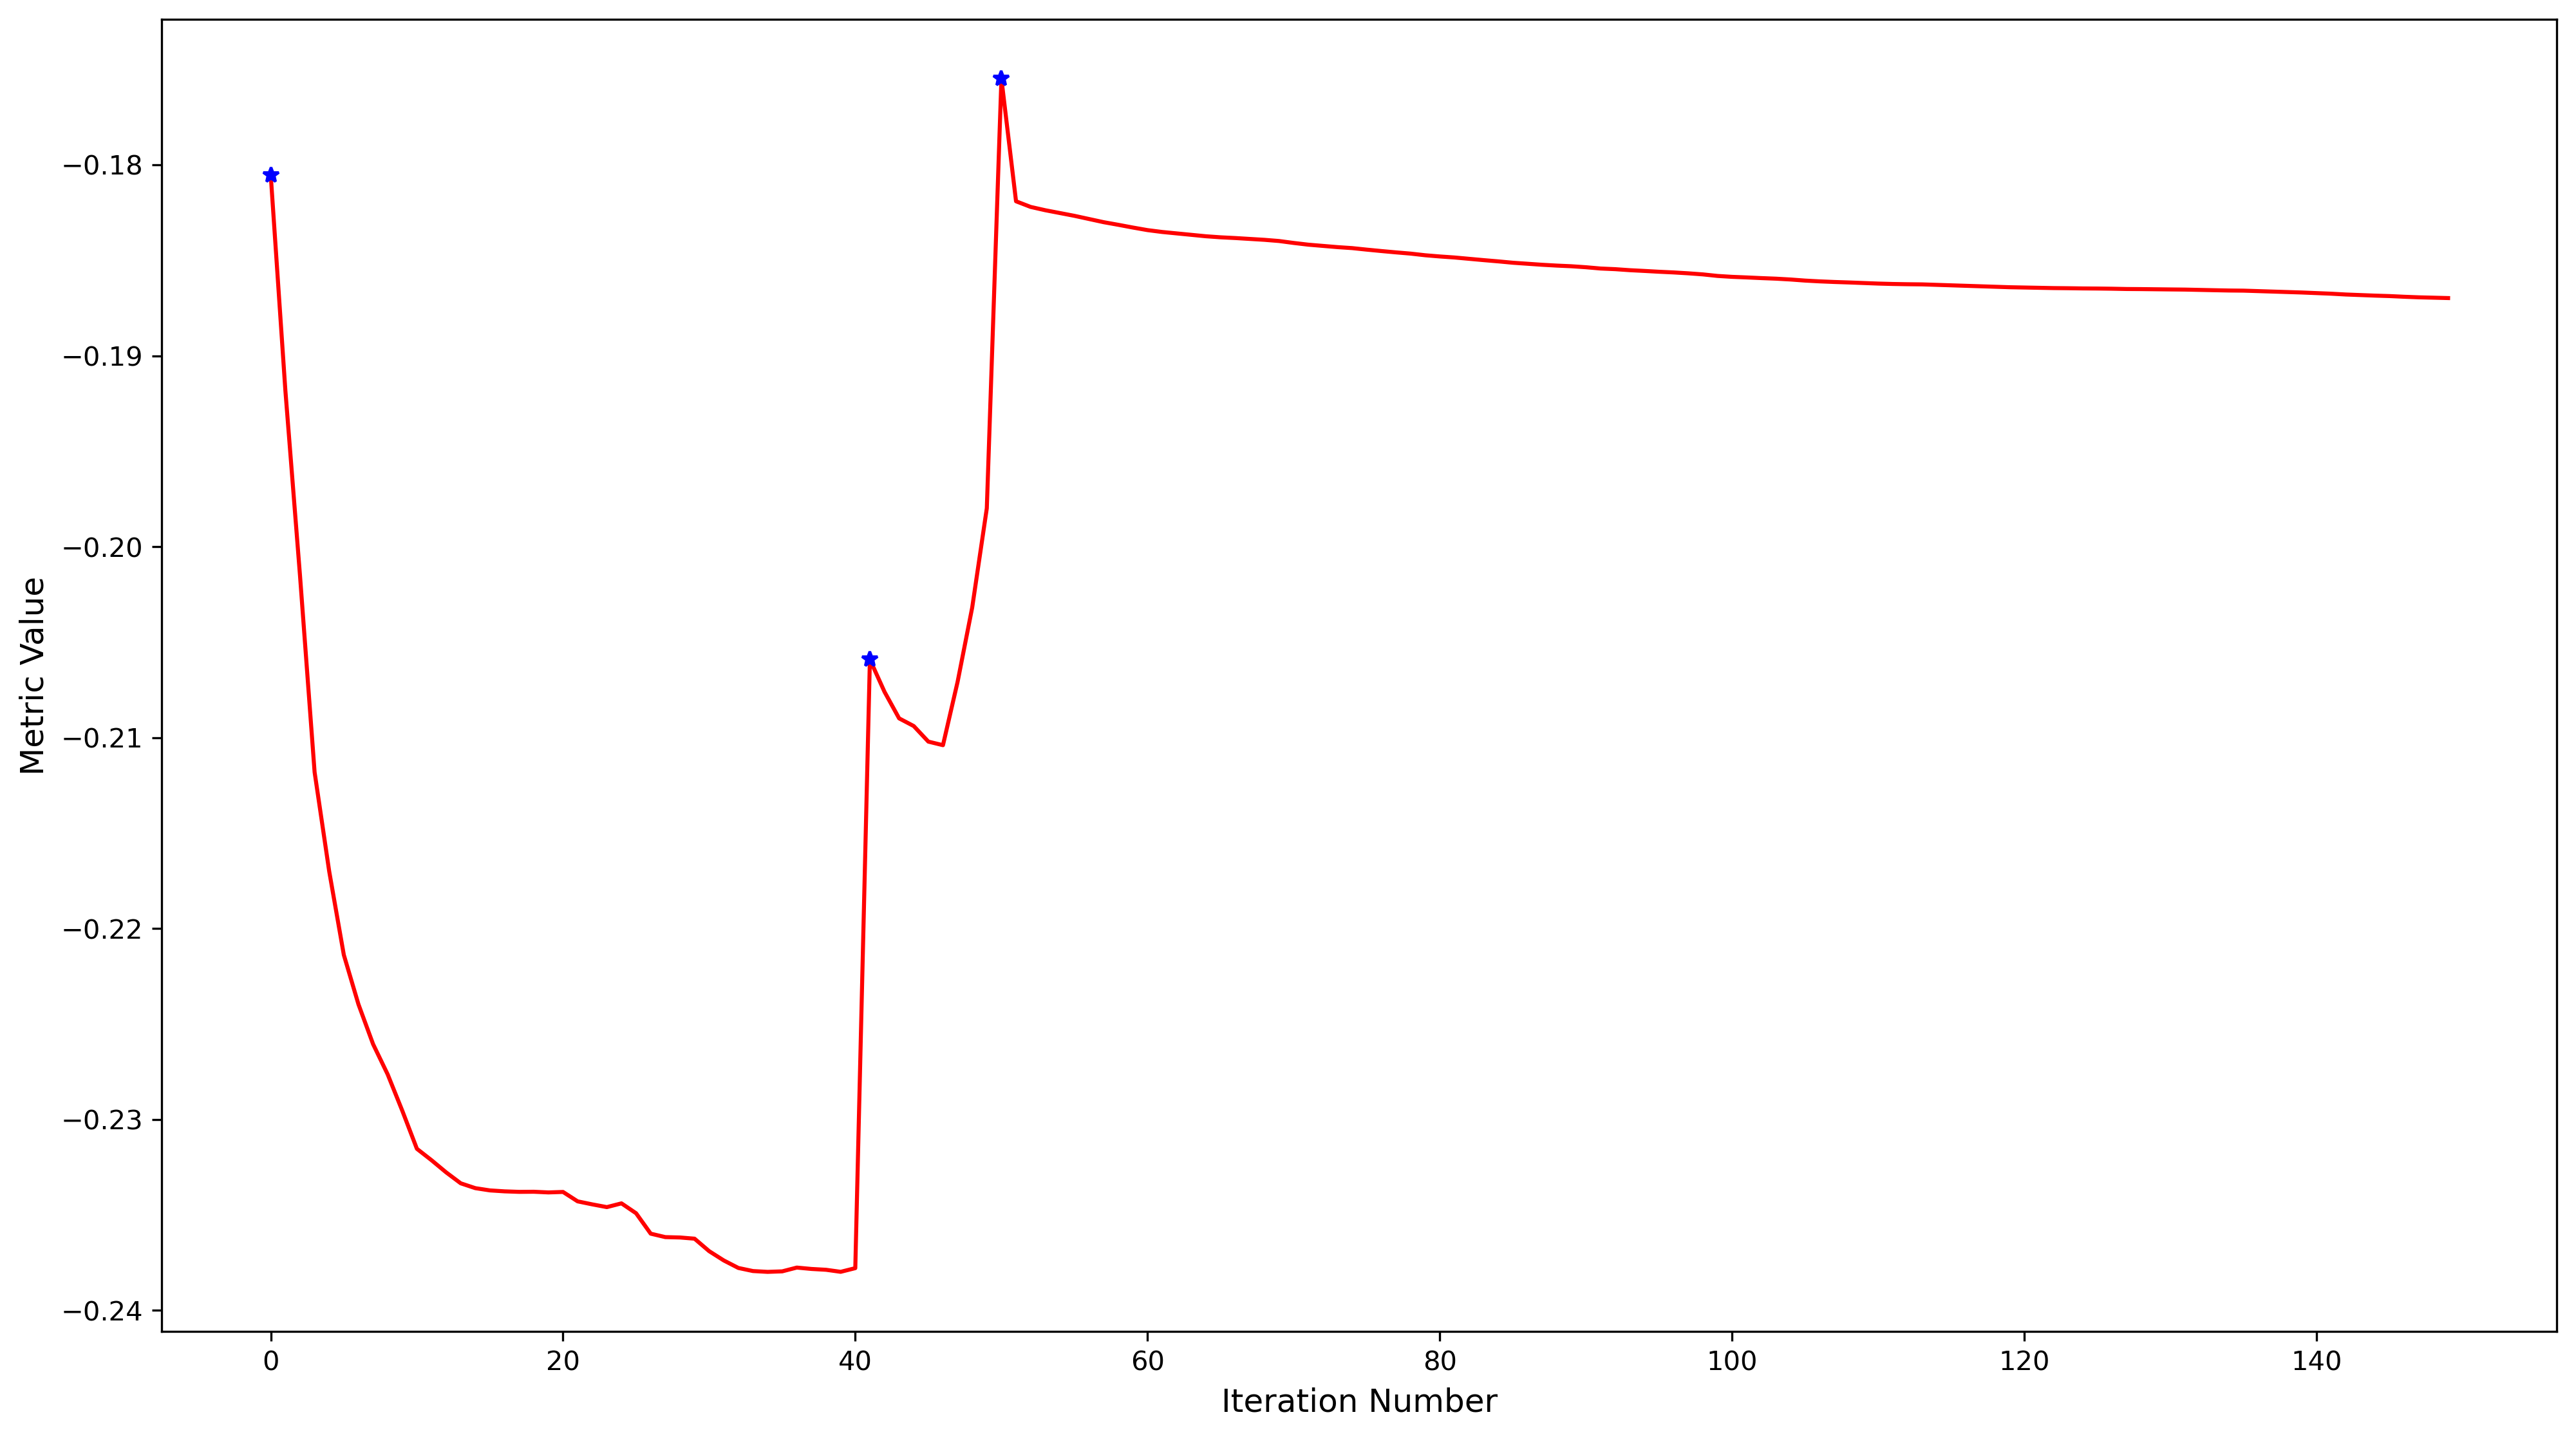

In [333]:
# Copied as is from SimpleITK notebook
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image,
                                                        sitk.sitkFloat32),
                                              sitk.Cast(moving_image,
                                                        sitk.sitkFloat32))

In [334]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}")

Final metric value: -0.18697646898374048
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [335]:
# We should probably save the transformation somewhere
# print(final_transform)

In [336]:
# Resample image
moving_resampled = sitk.Resample(moving_image,
                                 fixed_image,
                                 final_transform,
                                 sitk.sitkLinear,
                                 0.0,
                                 moving_image.GetPixelID())

In [337]:
# Save out registered image
moving_resampled_filename = os.path.join(os.path.dirname(Data.Folder[whichone]),
                                         '%s.registered_with.%s.downsampled_%sx.tif' % (Data.Sample[whichone],
                                                                                        Data.Sample[whichone],
                                                                                        downsample))
if not os.path.exists(moving_resampled_filename):
    print('Saving registered image to %s' % moving_resampled_filename[len(Root):])
    sitk.WriteImage(moving_resampled, moving_resampled_filename)
else:
    print('Already written to %s' % moving_resampled_filename[len(Root):])

Saving registered image to /Foetus02/Foetus02.registered_with.Foetus02.downsampled_4x.tif


In [338]:
# Save fixed image, resampled
fixed_resampled_filename = os.path.join(os.path.dirname(Data.Folder[len(Data)-1]),
                                        '%s.downsampled.%sx.tif' % (Data.Sample[len(Data)-1],
                                                                    downsample))
if not os.path.exists(fixed_resampled_filename):
    print('Saving resampled fixed image to %s' % fixed_resampled_filename[len(Root):])        
    sitk.WriteImage(fixed_image, fixed_resampled_filename)
else:
    print('Already written to %s' % fixed_resampled_filename[len(Root):])    

Already written to /Foetus02_Lugol_15pct_152d/Foetus02_Lugol_15pct_152d.downsampled.4x.tif


In [339]:
# Read images in again
img_fixed = dask_image.imread.imread(fixed_resampled_filename)
img_registered = dask_image.imread.imread(moving_resampled_filename)

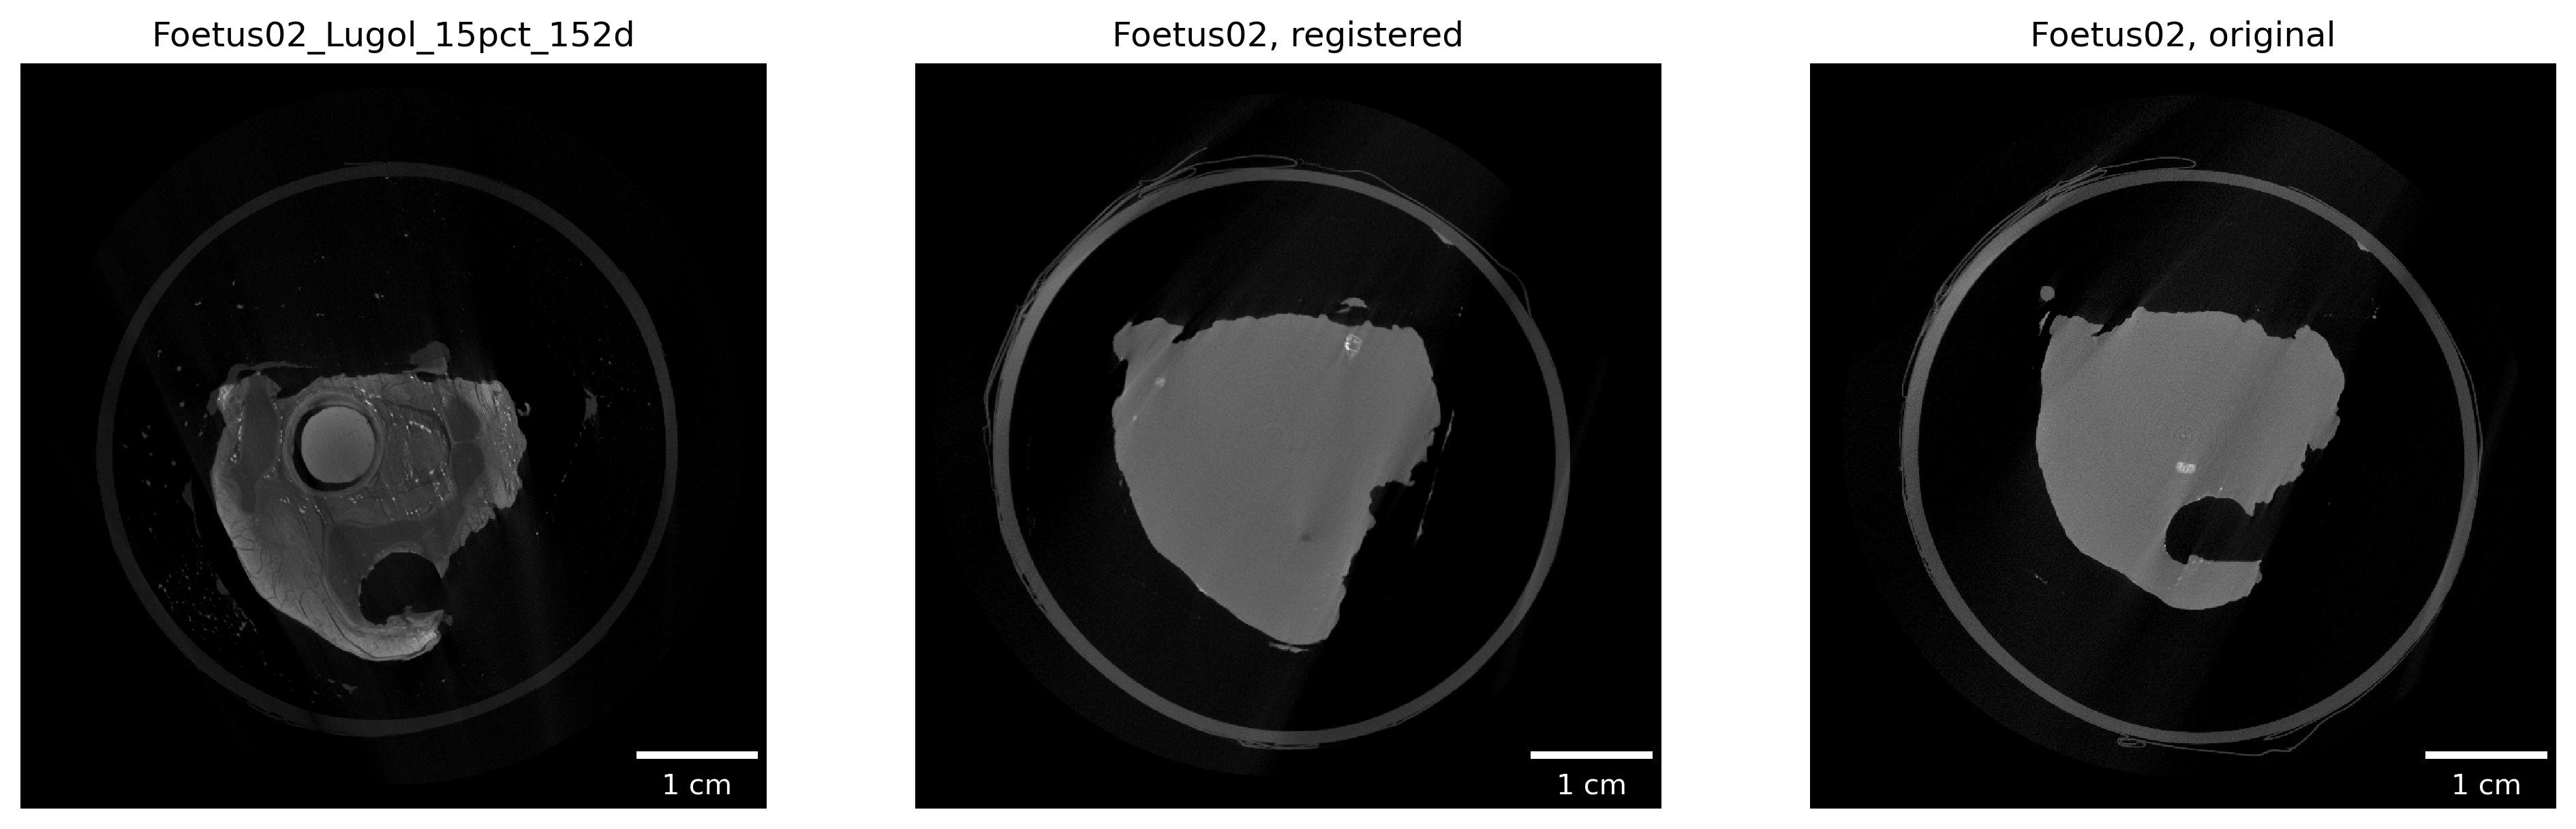

In [340]:
# Show what we did there
plt.subplot(131)
plt.imshow(img_fixed[img_fixed.shape[0]//2])
plt.title(Data.Sample[len(Data)-1])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][len(Data)-1]*downsample,'um'))
plt.axis('off')
plt.subplot(132)
plt.imshow(img_registered[img_registered.shape[0]//2])
plt.title('%s, registered' % Data.Sample[whichone])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone]*downsample,'um'))
plt.axis('off')
plt.subplot(133)
plt.imshow(Reconstructions[whichone][::downsample,::downsample,::downsample][Reconstructions[whichone][::downsample,::downsample,::downsample].shape[0]//2])
plt.title('%s, original' % Data.Sample[whichone])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone]*downsample,'um'))
plt.axis('off')
plt.savefig(os.path.join(os.path.dirname(Data.Folder[len(Data)-1]),
                         'Registration.%s.with.%s.png' % (Data['Sample'][whichone], Data['Sample'][len(Data)-1])),
            transparent=True,
            bbox_inches='tight')
plt.show()